In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import json
import os
import requests
import sys
import warnings
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import ShuffleSplit
from albumentations import (
    Compose, 
    ShiftScaleRotate,
)
from wandb.keras import WandbCallback

sys.path.append("..")
from utils.cam_utils import (
    get_img_arr,
    make_gradcam_heatmap,
    make_gradcam_img,
)
from utils.common import get_elapsed_time
from utils.data_utils import (
    load_tfrecord_dataset,
    mixup_dataset,
)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")
np.random.seed(42)

In [3]:
def view_img(img_arrs, labels, n_samples, label_names=None):
    n_cols = 5
    n_rows = n_samples // n_cols if n_samples % n_cols == 0 else n_samples // n_cols + 1
    fig = plt.figure(figsize=(n_cols * 4, n_rows * 3))
    for i in range(n_samples):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, xticks=[], yticks=[])
        ax.imshow(img_arrs[i])
        label = (
            labels[i].decode("utf-8")
            if label_names is None
            else label_names[f"c{str(labels[i])}"]
        )
        ax.set_title(f"Label: {label}")
        ax.axis("off")

In [4]:
config = configparser.ConfigParser()
_ = config.read(os.path.join("..", "conf", "config.ini"))

use_pseudo_label = False
proc_data_path = os.path.join("..", "proc_data")

project_name = config["project"]["project_name"]
run_name = config["project"]["run_name"]
raw_data_path = config["project"]["raw_data_path"]
raw_data_path = (
    os.path.join(raw_data_path, "pseudo_label") if use_pseudo_label else raw_data_path
)

fc_size = eval(config["model"]["fc_size"])
img_size = eval(config["model"]["img_size"])
n_epochs = eval(config["model"]["n_epochs"])
batch_size = eval(config["model"]["batch_size"])
initial_learning_rate = eval(config["model"]["initial_learning_rate"])
first_decay_steps = eval(config["model"]["first_decay_steps"])
use_adamw = eval(config["model"]["use_adamw"])
use_swa = eval(config["model"]["use_swa"])
use_mixup = eval(config["model"]["use_mixup"])
label_smoothing = eval(config["model"]["label_smoothing"])

label_names = {
    "c0": "safe driving",
    "c1": "texting - right",
    "c2": "talking on the phone - right",
    "c3": "texting - left",
    "c4": "talking on the phone - left",
    "c5": "operating the radio",
    "c6": "drinking",
    "c7": "reaching behind",
    "c8": "hair and makeup",
    "c9": "talking to passenger",
}

labels = list(label_names.keys())
num_classes = len(label_names)

os.makedirs(proc_data_path, exist_ok=True)

In [5]:
run = wandb.init(project=project_name, reinit=False)

if len(run_name) > 0:
    wandb.run.name = run_name
    wandb.run.save()
    
wandb.config.update(
    {
        "fc_size": fc_size,
        "img_size": img_size,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "initial_learning_rate": initial_learning_rate,
        "first_decay_steps": first_decay_steps,
        "use_adamw": use_adamw,
        "use_swa": use_swa,
        "use_mixup": use_mixup,
        "label_smoothing": label_smoothing,
        "use_pseudo_label": use_pseudo_label,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ... (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## An Input Data Pipeline Configuration with *Dataset* API

In [6]:
train_raw_data_path = os.path.join(raw_data_path, "imgs", "train")
test_raw_data_path = os.path.join(raw_data_path, "imgs", "test")

n_train_examples = len(
    tf.io.gfile.glob(os.path.join(train_raw_data_path, "*", "*.jpg"))
)

train_tfrec_paths = tf.io.gfile.glob(
    os.path.join(raw_data_path, "tfrec", "train", "*.tfrec")
)
test_img_paths = tf.io.gfile.glob(os.path.join(test_raw_data_path, "*.jpg"))

train_transforms = Compose(
    [
        ShiftScaleRotate(
            rotate_limit=(-20, 20),
            scale_limit=(0.0, 0.2),
            shift_limit_x=(-0.0625, 0.0625),
            shift_limit_y=(-0.046875, 0.046875),
            p=1.0,
        ),
    ]
)
valid_transforms = train_transforms

## Building and Compiling a Model

In [7]:
def get_model(
    img_size,
    fc_size,
    num_classes,
    initial_learning_rate,
    first_decay_steps,
    use_adamw,
    use_swa,
    label_smoothing,
    verbose=False,
):
    effnet = tf.keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3)
    )
    effnet.trainable = False
    
    x = tf.keras.layers.GlobalAveragePooling2D()(effnet.output)
    x = tf.keras.layers.Dense(fc_size, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(fc_size, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(effnet.input, output)
    
    if verbose:
        print(model.summary())

    # For tensorflow 2.5 or later, use tf.keras.optimizers.schedules.CosineDecayRestarts.
    lr_decayed_fn = tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate, first_decay_steps
    )
    optimizer = (
        tfa.optimizers.AdamW(lr_decayed_fn)
        if use_adamw
        else tfa.optimizers.RectifiedAdam(lr_decayed_fn)
    )
    if use_swa:
        optimizer = tfa.optimizers.SWA(optimizer, start_averaging=0, average_period=10)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=["acc"],
    )

    return model

## Model Training and Prediction

In [8]:
test_size = 0.25
train_steps_per_epoch = round(n_train_examples * (1.0 - test_size) / batch_size)
valid_steps_per_epoch = round(n_train_examples * test_size / batch_size)

rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
split = rs.split(range(len(train_tfrec_paths)))
train_index, valid_index = next(split)

model_path = os.path.join("..", "models")
serving_path = os.path.join("..", "models", "serving")
prediction_path = os.path.join("..", "predictions")
version = 1
os.makedirs(os.path.join(serving_path, str(version)), exist_ok=True)

In [9]:
with get_elapsed_time():
    one_train_dataset = load_tfrecord_dataset(
        np.array(train_tfrec_paths)[train_index],
        img_size,
        train_transforms,
        batch_size,
        num_classes=num_classes,
        normalize=False,
    )

    if use_mixup:
        oth_train_dataset = load_tfrecord_dataset(
            np.array(train_tfrec_paths)[train_index],
            img_size,
            train_transforms,
            batch_size,
            num_classes=num_classes,
            normalize=False,
        )
        zipped = tf.data.Dataset.zip((one_train_dataset, oth_train_dataset))
        train_dataset = zipped.map(
            lambda x, y: mixup_dataset(x, y, alpha=0.2),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    else:
        train_dataset = one_train_dataset

    valid_dataset = load_tfrecord_dataset(
        np.array(train_tfrec_paths)[valid_index],
        img_size,
        valid_transforms,
        batch_size,
        num_classes=num_classes,
        normalize=False,
    )

    suffix = "_to_serve"
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(model_path, f"model{suffix}.h5"),
            monitor="val_loss",
        ),
        WandbCallback(),
    ]

    model = get_model(
        img_size,
        fc_size,
        num_classes,
        initial_learning_rate,
        first_decay_steps,
        use_adamw,
        use_swa,
        label_smoothing,
    )

    model.fit(
        train_dataset,
        epochs=n_epochs,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=valid_dataset,
        validation_steps=valid_steps_per_epoch,
        callbacks=callbacks,
    )

    tf.keras.models.save_model(
        model,
        serving_path,
        overwrite=True,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
    )

print("The model training task has been successfully completed.")

Epoch 1/500
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-03-19 14:07:22.142 tensorflow-2-6-gpu-p-ml-p3-2xlarge-0d90a33bec970cd9f3bcca70fc5a:32093 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-19 14:07:22.173 tensorflow-2-6-gpu-p-ml-p3-2xlarge-0d90a33bec970cd9f3bcca70fc5a:32093 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
526/526 [==============================] - 135s 233ms/step - loss: 1.5026 - acc: 0.5153 - val_loss: 0.4822 - val_acc: 0.8645
Epoch 2/500
526/526 [==============================] - 122s 233ms/step - loss: 0.9496 - acc: 0.7499 - val_loss: 0.6305 - val_acc: 0.8107
Epoch 3/500
526/526 [=========

INFO:tensorflow:Assets written to: ../models/serving/assets


Elapsed time: 2158 sec
The model training task has been successfully completed.


## Model Explainability with Guided Grad-CAM

In [10]:
n_samples = 20
sampled_img_paths = np.random.choice(test_img_paths, n_samples)
last_conv_layer_name = "top_conv"
gradcam_img_arrs, labels = [], []

for img_path in sampled_img_paths:
    img_arr = get_img_arr(img_path, (img_size, img_size))
    heatmap_arr, label = make_gradcam_heatmap(img_arr, model, last_conv_layer_name)
    gradcam_img_arr = make_gradcam_img(
        img_path,
        heatmap_arr,
        cam_path=os.path.join(proc_data_path, img_path.split(os.path.sep)[-1]),
    )
    gradcam_img_arrs.append(gradcam_img_arr / 255.0)
    labels.append(label.numpy())

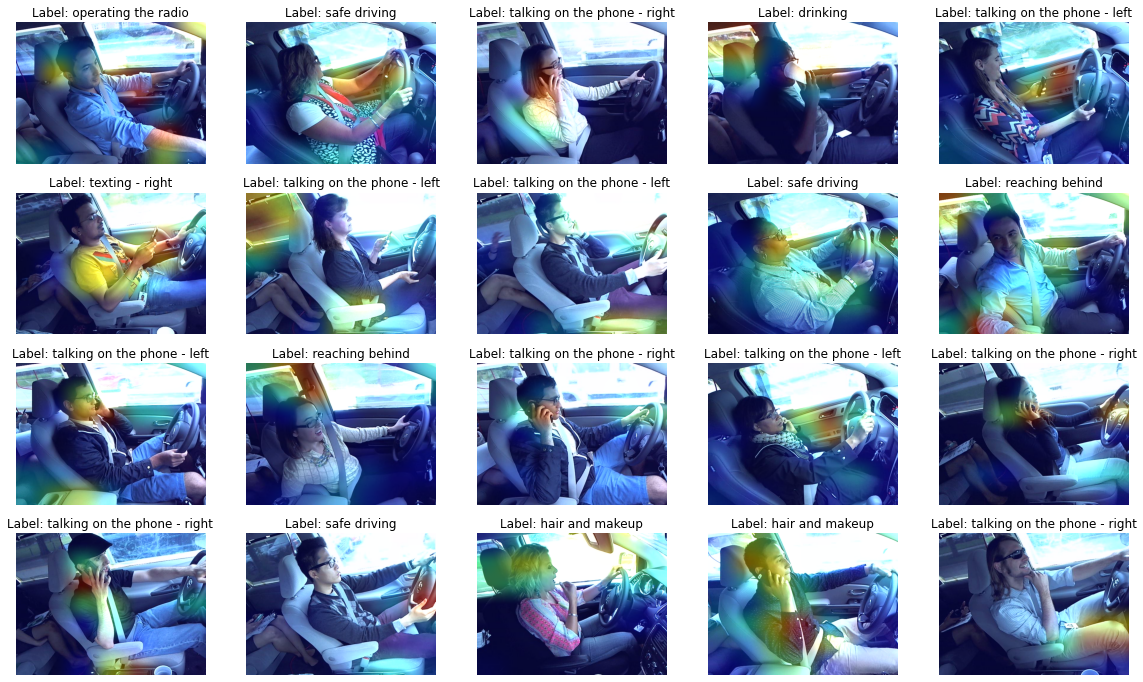

In [11]:
view_img(gradcam_img_arrs, labels, n_samples, label_names)

In [12]:
columns = ["image_id", "image", "label"]
data = []
for img_path, label in zip(
    sampled_img_paths,
    labels,
):
    data.append(
        [
            img_path.split(os.path.sep)[-1],
            wandb.Image(os.path.join(proc_data_path, img_path.split(os.path.sep)[-1])),
            label_names[f"c{str(label)}"],
        ]
    )

gradcam_img_table = wandb.Table(data=data, columns=columns)
wandb.log({"gradcam_img_table": gradcam_img_table})
run.finish()

acc,▁▅▄▆▇▇▅▆▇▇███▇▆▆▇
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▃▄▃▂▂▄▃▂▂▁▁▁▂▃▂▂
val_acc,▃▁▃▇▇▄▅▇▇████▆▇▇▇
val_loss,▆█▅▂▂▅▃▂▂▂▁▁▁▃▂▂▂
acc,0.81434
best_epoch,11
best_val_loss,0.08185
epoch,16
loss,0.80218
val_acc,0.96482


## *TF Serving* Testing
* You need to download and run the docker image via `scripts/run.sh` file.

In [13]:
%%time
sampled_img_arrs = np.stack(sampled_img_arrs, axis=0)

data = json.dumps(
    {"signature_name": "serving_default", "instances": sampled_img_arrs.tolist()}
)
headers = {"content-type": "application/json"}
model_url = f"http://localhost:8501/v{str(version)}/models/state-farm-detection:predict"
json_response = requests.post(model_url, data=data, headers=headers)
predictions = json.loads(json_response.text)["predictions"]
predictions = np.array(predictions)

In [14]:
view_image(sampled_imgs, np.argmax(predictions, axis=1), n_samples, label_names)